<span style="color:deeppink; font-size:35px;"><b> Days since September 1 when condition is first met over the years (including ENSO years)</b></span>

# using SILO

Location: DARWIN AIRPORT
Latitude: -12.41
Longitude: 130.88

Threshold: 50 mm

GBOS:
1900: 25-09-1900
1901: 23-12-1901
1902: 19-12-1902
1903: 21-10-1903
1904: 02-11-1904
1905: 23-02-1906
1906: 06-11-1906
1907: 06-10-1907
1908: 06-12-1908
1909: 08-11-1909
1910: 10-11-1910
1911: 31-10-1911
1912: 09-12-1912
1913: 03-01-1914
1914: 23-12-1914
1915: 13-12-1915
1916: 15-10-1916
1917: 19-09-1917
1918: 26-12-1918
1919: 17-01-1920
1920: 23-11-1920
1921: 28-12-1921
1922: 18-12-1922
1923: 14-12-1923
1924: 23-10-1924
1925: 10-01-1926
1926: 24-11-1926
1927: 06-11-1927
1928: 21-12-1928
1929: 27-12-1929
1930: 01-11-1930
1931: 12-11-1931
1932: 02-11-1932
1933: 27-10-1933
1934: 22-10-1934
1935: 04-12-1935
1936: 15-12-1936
1937: 21-12-1937
1938: 02-11-1938
1939: 28-12-1939
1940: 14-11-1940
1941: 11-11-1941
1942: 21-09-1942
1943: 22-10-1943
1944: 29-10-1944
1945: 12-11-1945
1946: 16-12-1946
1947: 25-10-1947
1948: 01-12-1948
1949: 10-12-1949
1950: 23-11-1950
1951: 11-10-1951
1952: 10-11-1952
1953: 05-12-19

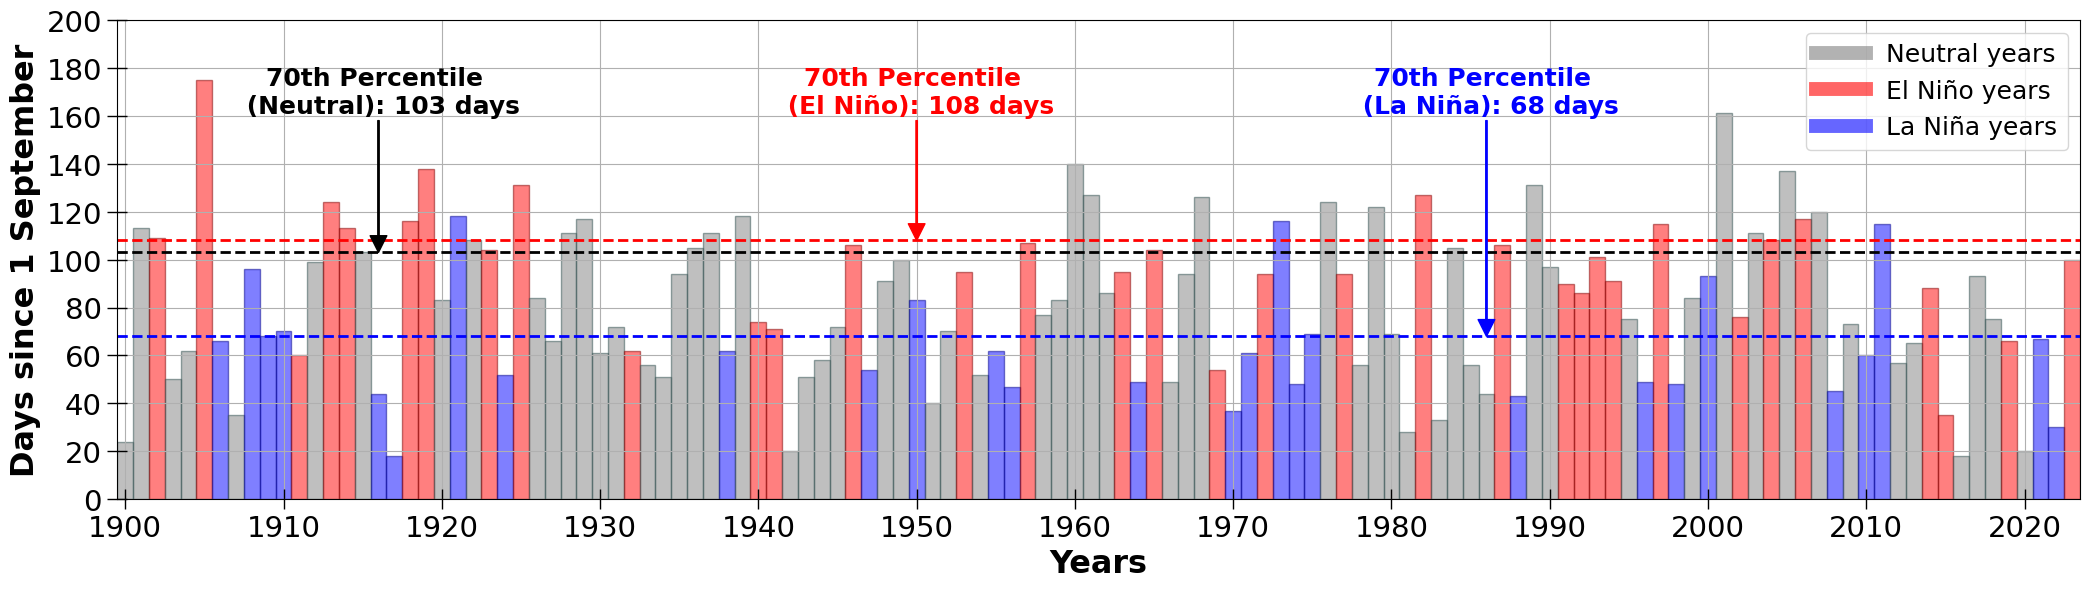

In [5]:
import dask
from dask.distributed import Client
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import logging
logging.getLogger("distributed.scheduler").setLevel(logging.ERROR)

# ANSI escape code for bold text
BOLD = '\033[1m'
RESET = '\033[0m'

dataset_used = "SILO"

start_yr = 1900
end_yr = 2024

threshold_rain = 50

# Create a Dask distributed client (for parallel processing - faster code run)
client = Client()

# Load the path to the Excel file with Northern Australian locations
excel_file_path = '/g/data3/dx2/rn0550/Green_Date/GBOS_calculation/Green_date_locations.xlsx'
data = pd.read_excel(excel_file_path, sheet_name='Sheet1')

# Specify the location name you want to search for (case-insensitive)
desired_location = 'darwin'.lower() 

data['FirstWord'] = data['Location'].str.split().str[0].str.lower()

if desired_location in data['FirstWord'].values:
    target_lat = data.loc[data['FirstWord'] == desired_location, 'Lat'].values[0]
    target_lon = data.loc[data['FirstWord'] == desired_location, 'Lon'].values[0]
    print(f"{BOLD}Location:{RESET} {data.loc[data['FirstWord'] == desired_location, 'Location'].values[0].upper()}")
    print(f"{BOLD}Latitude:{RESET} {target_lat}")
    print(f"{BOLD}Longitude:{RESET} {target_lon}")
else:
    print(f"{BOLD}Location '{desired_location}' not found in the Excel file.")
print()

######################################################################################
######################################################################################
# Specify the file path and threshold_rain as before
file_path = '/g/data/dx2/rn0550/Green_Date/SILO_daily_rainfall/'

print(f"{BOLD}Threshold:{RESET} {threshold_rain} mm")

# Function to process a single year's data/observations
def process_year(year):
    current_year_file = f'{file_path}{year}.daily_rain.nc'
    next_year_file = f'{file_path}{year + 1}.daily_rain.nc'

    ds = xr.open_mfdataset([current_year_file, next_year_file], concat_dim='time', combine='nested',
                           chunks={'time': 'auto'})

    ds['time'] = pd.to_datetime(ds['time'].values)

    start_date = pd.to_datetime(f'{year}-09-01')
    end_date = pd.to_datetime(f'{year + 1}-04-30')
    selected_data = ds['daily_rain'].sel(time=slice(start_date, end_date))
    selected_data_location = selected_data.sel(lat=target_lat, lon=target_lon, method='nearest')

    rolling_sum = selected_data_location.rolling(time=3, min_periods=1).sum()
    rolling_sum = rolling_sum.compute()

    green_dates_indices = rolling_sum['time'][rolling_sum >= threshold_rain]

    if green_dates_indices.any():
        first_green_date = green_dates_indices.values[0].astype('M8[D]').astype('O')
        formatted_date = first_green_date.strftime("%d-%m-%Y")
        return formatted_date
    else:
        return None

# Using Dask to parallelise the processing for multiple years
years = range(start_yr, end_yr)
futures = client.map(process_year, years)
green_dates = client.gather(futures)
green_dates = [date for date in green_dates if date is not None]

######################################################################################
######################################################################################
# Print the list of green dates in day-month-year format
print()
print(BOLD + 'GBOS:' + RESET)

# Create a list to store the years with green dates
years_with_green_dates = []

for green_date in green_dates:
    # Extract the year from the green date
    year = int(green_date[-4:])
    
    # Check if the green date falls within the specified range
    if 9 <= int(green_date[3:5]) <= 12:  # Check if the month is between September and December
        print(f"{year}: {green_date}")
        years_with_green_dates.append(year)
    elif 1 <= int(green_date[3:5]) <= 4:  # Check if the month is between January and April
        print(f"{year - 1}: {green_date}")
        years_with_green_dates.append(year - 1)

# Print years with no green dates
print()
print(BOLD + 'Years with no GBOS dates:' + RESET)
for year in range(start_yr, end_yr):
    if year not in years_with_green_dates:
        print(f"{year}: No GBOS date found")
        
print()  

######################################################################################
###################################################################################### 
# Calculate the difference in days from September 1st
days_difference_list = []

def days_difference_from_september_1(green_dates):
    reference_date = datetime.strptime("01-09", "%d-%m")
    days_differences = []

    for year in range(start_yr, end_yr):
        if year in years_with_green_dates:
            green_date = green_dates[years_with_green_dates.index(year)]
            # Extract day and month
            day_month_str = green_date[:-5]
            green_date_obj = datetime.strptime(day_month_str, "%d-%m")

            # Calculate the difference in days from September 1st
            if green_date_obj.month > reference_date.month or (green_date_obj.month == reference_date.month and green_date_obj.day >= reference_date.day):
                # If the green date is on or after September 1st of the same year
                days_difference = (green_date_obj - reference_date).days
            else:
                # If the green date is before September 1st of the same year, calculate the difference from last year's September 1st
                last_year_reference_date = reference_date.replace(year=green_date_obj.year - 1)
                days_difference = (green_date_obj - last_year_reference_date).days

            days_differences.append(days_difference)
        else:
            # For years without green dates, append None to the list
            days_differences.append(None)

    return days_differences

######################################################################################
###################################################################################### 
# Calculate and print the days differences
days_difference_list = days_difference_from_september_1(green_dates)

# Print the list of the number of days between each green date and September 1st of the respective year
print("Number of days between each green date and September 1st of the respective year:")
print(days_difference_list)
print()


client.close()

######################################################################################
###################################################################################### 
# Read El Niño and La Niña years from Excel file
excel_file_path = '/g/data/dx2/rn0550/Green_Date/GBOS_calculation/Green_date_locations.xlsx'
el_nino_df = pd.read_excel(excel_file_path, sheet_name='Sheet2', usecols=['El Niño'])
la_nina_df = pd.read_excel(excel_file_path, sheet_name='Sheet2', usecols=['La Niña'])

el_nino_years = el_nino_df.dropna()['El Niño'].astype(int).tolist()
la_nina_years = la_nina_df.dropna()['La Niña'].astype(int).tolist()


# Find the 70th percentile index
# Filter out None values before sorting
sorted_days_difference_list = sorted(filter(lambda x: x is not None, days_difference_list))
percentile_days_diff_70 = np.percentile(sorted_days_difference_list, 70, interpolation='nearest')
percentile_days_diff_70 = int(percentile_days_diff_70)
start_date = datetime(year=1900, month=9, day=1)  
green_date_70 = start_date + timedelta(days=percentile_days_diff_70)
formatted_date_70 = green_date_70.strftime('%d-%m')

# The 70th percentile of the day-month green dates for all years
print('The 70th percentile of the day-month of the first green date for all years is:')
print(BOLD + formatted_date_70 + RESET)

# Filter out None values before calculating percentiles
valid_days_difference_list = [days for days in days_difference_list if days is not None]

# Calculate the 70th percentile days since September 1st for El Niño and La Niña years
el_nino_days_diff_70 = np.percentile([days for year, days in zip(years, valid_days_difference_list) if year in el_nino_years], 70, interpolation='nearest')
la_nina_days_diff_70 = np.percentile([days for year, days in zip(years, valid_days_difference_list) if year in la_nina_years], 70, interpolation='nearest')

# Function to convert days difference to date
def days_difference_to_date(days_difference, start_date):
    days_difference = int(days_difference)
    
    # Calculate the reference date
    reference_date = start_date + timedelta(days=days_difference)
    
    # Format the date as day-month
    return reference_date.strftime('%d-%m')

# Convert 70th percentile days difference for El Niño to day-month format
formatted_date_el_nino = days_difference_to_date(el_nino_days_diff_70, start_date)
# Print the 70th percentiles for El Niño and La Niña years
print('The 70th percentile of the day-month of the first green date for' ' ' '\033[91m' + 'El Niño' + '\033[0m' ' ' 'years is:')
print(BOLD + '\033[91m' + formatted_date_el_nino + '\033[0m' + RESET)

# Convert 70th percentile days difference for La Niña to day-month format
formatted_date_la_nina = days_difference_to_date(la_nina_days_diff_70, start_date)
print('The 70th percentile of the day-month of the first green date for' ' ' '\033[94m' + 'La Niña' + '\033[0m' ' ' 'years is:')
print(BOLD + '\033[94m' + formatted_date_la_nina + '\033[0m' + RESET)

######################################################################################
###################################################################################### 
# Replace None values with a placeholder (999 in this case)
days_difference_list_plot = [999 if val is None else val for val in days_difference_list]

###################################################################################### 
# Replace 999 with 0
days_difference_list_plot = [0 if val == 999 else val for val in days_difference_list_plot]

###################################################################################### 
# Create a figure and axis for the plot
plt.figure(figsize=(21, 6))

bar_colors = [('red', 'maroon') if year in el_nino_years else
              ('blue', 'darkblue') if year in la_nina_years else
              ('grey', 'darkslategrey') for year in years]

# Plot the 'years' along the x-axis and 'days after Sep 1 when the condition is first met' along the y-axis as a bar chart
bars = plt.bar(years, days_difference_list_plot, 
               color=[color for color, _ in bar_colors],  # Bar face colors
               edgecolor=[edge_color for _, edge_color in bar_colors],  # Bar edge colors
               alpha=0.5, width=1, label='All Years')   


# Mark the green date with a horizontal line along the y-axis
plt.axhline(y=percentile_days_diff_70, color='black', linestyle='--', linewidth=2, label='70th Percentile Green Date')
years_list = list(years)
#plt.text(min(years_list) + 30, percentile_days_diff_70, f'70th Percentile (Neutral Years): {percentile_days_diff_70} days or {formatted_date_70}',
#         color='black', fontsize=16, va='bottom', ha='left', fontweight='bold')

# Mark the 70th percentile of El Niño and La Niña years with horizontal lines
plt.axhline(y=el_nino_days_diff_70, color='red', linestyle='--', linewidth=2, label='70th Percentile (El Niño)')
plt.axhline(y=la_nina_days_diff_70, color='blue', linestyle='--', linewidth=2, label='70th Percentile (La Niña)')


plt.annotate('', xy=(1916, percentile_days_diff_70), xytext=(1916, percentile_days_diff_70+55), arrowprops=dict(facecolor='black', edgecolor='black', shrink=0, width=1), fontsize=18)
        
plt.text(1916, 170, f'70th Percentile \n (Neutral): {percentile_days_diff_70} days', color='black', fontsize=18, fontweight='bold', 
         horizontalalignment='center', verticalalignment='center')


plt.annotate('', xy=(1950, el_nino_days_diff_70), xytext=(1950, el_nino_days_diff_70+50), arrowprops=dict(facecolor='red', edgecolor='red', shrink=0, width=1), fontsize=18)
        
plt.text(1950, 170, f'70th Percentile \n (El Niño): {el_nino_days_diff_70} days', color='red', fontsize=18, fontweight='bold', 
         horizontalalignment='center', verticalalignment='center')



plt.annotate('', xy=(1986, la_nina_days_diff_70), xytext=(1986, la_nina_days_diff_70+90), arrowprops=dict(facecolor='blue', edgecolor='blue', shrink=0, width=1), fontsize=18)
        
plt.text(1986, 170, f'70th Percentile \n (La Niña): {la_nina_days_diff_70} days', color='blue', fontsize=18, fontweight='bold', 
         horizontalalignment='center', verticalalignment='center')



# Set labels and title
plt.xlabel('Years', fontsize=23, fontweight='bold')
plt.ylabel('Days since 1 September', fontsize=23, fontweight='bold')

title_line1 = f"Days since 1 September when condition is first met over the years"
title_line2 = f"Location: {data.loc[data['FirstWord'] == desired_location, 'Location'].values[0].upper()}, ({target_lat:.2f}, {target_lon:.2f}), Threshold Rain: {threshold_rain} mm, Dataset Used: {dataset_used}"
#plt.title(f"{title_line1}\n{title_line2}", fontsize=23, fontweight='bold')

legend_labels = [
    'Neutral years',
    'El Niño years',
    'La Niña years'
]
legend_handles = [
    plt.Line2D([0], [0], color='grey', linewidth=10, alpha=0.6),
    plt.Line2D([0], [0], color='red', linewidth=10, alpha=0.6),
    plt.Line2D([0], [0], color='blue', linewidth=10, alpha=0.6)
]

plt.legend(handles=legend_handles, labels=legend_labels, fontsize=18)

plt.tick_params(axis='both', which='both', labelsize=21, length=15, width=1, direction='inout')


plt.gca().set_ylim(0, 200)
plt.yticks(range(0, 201, 20))

# Set x-axis limits to start from 1900 and end at 2023
plt.xticks(range(1900, 2024, 10))
plt.xlim(1899.5, 2023.5) 

plt.grid(True)
plt.tight_layout()


#plt.savefig(f"/g/data/dx2/rn0550/Green_Date/FIGURES_for_GD_PAPER/Days_since_Sep_1_when_condition_is_first_met_with_elnino_yrs_{data.loc[data['FirstWord'] == desired_location, 'Location'].values[0].upper()}.png", dpi=100, orientation='landscape', bbox_inches='tight')


plt.show()



<span style="color:deeppink; font-size:35px;"><b> Observed Green Date calculation </b></span>

# GBOS for all years 
For each year, find the day on which the 3-day rolling sum of rainfall reaches 50 mm after 1 Sep - store the dates as number of days since 1 Sep when threshold is met

In [13]:
import xarray as xr
import pandas as pd
import dask.distributed
import time

# Define the base path where the files are located
file_path = '/g/data/dx2/rn0550/Green_Date/SILO_daily_rainfall/'

# Define the threshold
threshold_rain = 30

# Function to process data for each file
def process_file(combined_data, threshold_rain):
    def calculate_days_difference(date):
        if pd.isnull(date):  # Check if date is NaN
            return 999
        if date.month >= 9 and date.month <= 12:
            start_date = pd.Timestamp(f"{date.year}-09-01")
        elif date.month >= 1 and date.month <= 4:
            start_date = pd.Timestamp(f"{date.year - 1}-09-01")
        else:
            start_date = pd.Timestamp(f"{date.year}-09-01")
        return (date - start_date).days + 1

    # Compute the rolling sum over 3 days
    rolling_sum = combined_data.rolling(time=3, min_periods=1).sum()

    # Find the first instance where the rolling sum is >= threshold
    condition = rolling_sum >= threshold_rain
    first_event_dates = condition.idxmax(dim='time').where(condition.max(dim='time'), drop=False)

    # Convert to pandas DataFrame
    df = first_event_dates.to_dataframe(name="time")

    # Apply the function to the 'time' column
    df["time"] = df["time"].apply(calculate_days_difference)

    # Convert back to xarray DataArray
    updated_first_event_dates = xr.DataArray(
        df["time"].values.reshape(first_event_dates.shape),
        dims=("lat", "lon"),
        coords={"lat": first_event_dates.lat, "lon": first_event_dates.lon},
    )

    return updated_first_event_dates


# Create a Dask client (using threads)
if __name__ == '__main__':

    client = dask.distributed.Client(processes=False)

    # Record the start time
    start_time = time.time()

    days_diff_values_list = []  # Initialise the list to store DataArrays

    for start_yr in range(1900, 2024):
        end_yr = start_yr + 1
        # SILO
        current_year_file = f'{file_path}{start_yr}.daily_rain.nc'
        next_year_file = f'{file_path}{start_yr + 1}.daily_rain.nc'
        ds = xr.open_mfdataset([current_year_file, next_year_file], concat_dim='time', combine='nested',
                               chunks={'time': 'auto', 'lat': 'auto', 'lon': 'auto'})
        

        start_date = pd.to_datetime(f'{start_yr}-09-01')
        end_date = pd.to_datetime(f'{start_yr + 1}-04-30')

        # Apply the land mask to rainfall data
        selected_data = ds['daily_rain'].sel(time=slice(start_date, end_date)).load() # AGCD: 'precip'
        #print(selected_data)

        print("Processing data for year:", start_yr)

        # Process and get days_differences for the current year
        days_differences_result = process_file(selected_data, threshold_rain)

        # Create a DataArray for the current year
        data_array = xr.DataArray(
            data=days_differences_result.values.reshape((1, *days_differences_result.shape)),
            dims=("time", "lat", "lon"),
            coords={"time": [start_yr], "lat": days_differences_result.lat, "lon": days_differences_result.lon},
        )

        # Append DataArray to the list
        days_diff_values_list.append(data_array)

    # Concatenate all DataArrays along the 'time' dimension
    days_diff_values = xr.concat(days_diff_values_list, dim="time")

    # Print the shape of the final DataArray
    print("Shape of days_diff_values:", days_diff_values.shape)
    print(days_diff_values)
    
    #days_diff_values.to_netcdf(f"/g/data/dx2/rn0550/Green_Date/GBOS_calculation/Forecasting_GD/NEW_GBOS_hindcasts_26Aug2024/TEST_OBS/SILO_days_diff_values_{threshold_rain}mm_1900_2023.nc")
    

    # Close the dataset
    ds.close()

    # Print elapsed time
    print(f"Elapsed time: {time.time() - start_time:.2f} seconds")



Processing data for year: 1900
Processing data for year: 1901
Processing data for year: 1902
Processing data for year: 1903
Processing data for year: 1904
Processing data for year: 1905
Processing data for year: 1906
Processing data for year: 1907
Processing data for year: 1908
Processing data for year: 1909
Processing data for year: 1910
Processing data for year: 1911
Processing data for year: 1912
Processing data for year: 1913
Processing data for year: 1914
Processing data for year: 1915
Processing data for year: 1916
Processing data for year: 1917
Processing data for year: 1918
Processing data for year: 1919
Processing data for year: 1920
Processing data for year: 1921
Processing data for year: 1922
Processing data for year: 1923
Processing data for year: 1924
Processing data for year: 1925
Processing data for year: 1926
Processing data for year: 1927
Processing data for year: 1928
Processing data for year: 1929
Processing data for year: 1930
Processing data for year: 1931
Processi

<span style="color:deeppink; font-size:35px;"><b> Green Date Calculation (70th percentile GBOS across all years) </b></span>

In [12]:
import numpy as np
import xarray as xr

method = 999
threshold = 30
year = 1900

# Load the NetCDF file
ds = xr.open_dataset(f"/g/data/dx2/rn0550/Green_Date/GBOS_calculation/Forecasting_GD/NEW_GBOS_hindcasts_26Aug2024/TEST_OBS/SILO_days_diff_values_{threshold}mm_{year}_2023.nc")

# Calculate the 70th percentile along the time dimension
percentile_70 = np.percentile(ds['__xarray_dataarray_variable__'], q=70, axis=0, interpolation='nearest')

# Calculate the percentage of '999' values along the time dimension
total_years = ds['__xarray_dataarray_variable__'].shape[0]
count_999 = np.sum(ds['__xarray_dataarray_variable__'] == 999, axis=0)
percentage_999 = count_999 / total_years * 100

# Replace percentile values where '999' percentage is greater than 33% with '999'
percentile_70 = np.where(percentage_999 > 33, np.nan, percentile_70)

# Create a new xarray dataset for the percentile values
percentile_ds = xr.Dataset(
    {
        'percentile_70': (['lat', 'lon'], percentile_70)
    },
    coords={
        'lat': ds['lat'],
        'lon': ds['lon']
    }
)

# Save the result to a new NetCDF file
print(percentile_70.shape)

# Save the result to a NetCDF file
#output_file = f'/g/data/dx2/rn0550/Green_Date/GBOS_calculation/Forecasting_GD/NEW_GBOS_hindcasts_26Aug2024/TEST_OBS/70th_percentile_with_{method}_{threshold}mm_33%ofallyrs_condition_{year}_2023.nc'
#percentile_ds.to_netcdf(output_file)

#print("70th percentile values calculated and saved to:", output_file)


# Write the values to a file
#with open(f'/g/data/dx2/rn0550/Green_Date/GBOS_calculation/GD_MAP_data/50mm/NEW_GD_map_data/70th_percentile_with_{method}_{threshold}mm_37%ofallyrs_condition.txt', "w") as file:
#    for value in percentile_70:
#        file.write(f"{value}\n")



(681, 841)


# Green Date - Maps

Number of colors: 18
Number of bounds/levels: 19
Number of values between 0 and 30: <xarray.DataArray 'percentile_70' ()> Size: 8B
array(0)
Number of values between 214 and 250: <xarray.DataArray 'percentile_70' ()> Size: 8B
array(1492)
Number of values between 0 and 30: <xarray.DataArray 'percentile_70' ()> Size: 8B
array(0)
Number of values between 214 and 250: <xarray.DataArray 'percentile_70' ()> Size: 8B
array(1195)


/jobfs/150018475.gadi-pbs/ipykernel_1076047/3160247807.py:197: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


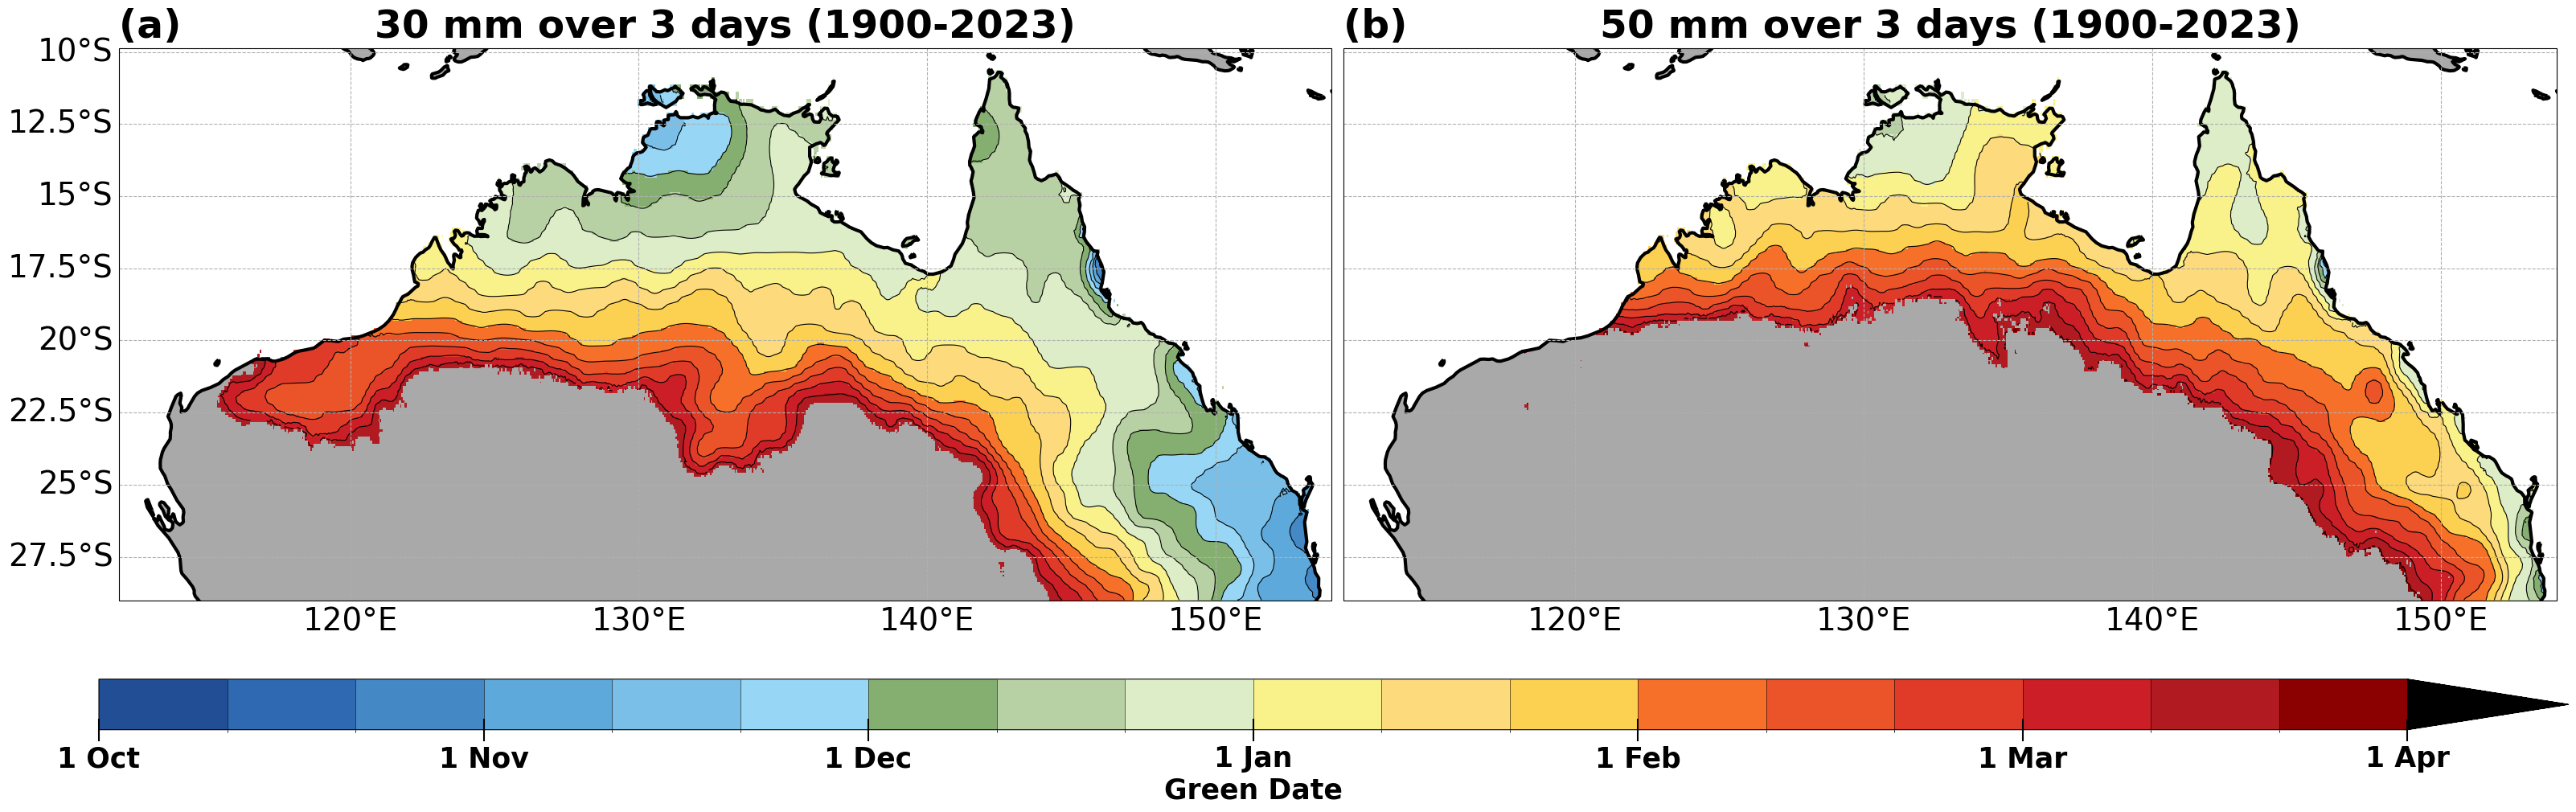

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import datetime
import scipy.ndimage
import cartopy.feature as cfeature
import matplotlib as mpl
from scipy.ndimage import gaussian_filter
import scipy.ndimage as ndimage
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.colorbar import ColorbarBase
from skimage.measure import find_contours
from matplotlib.colorbar import ColorbarBase

def filter_nan_gaussian_conserving(arr, sigma):
    """Apply a gaussian filter to an array with nans.
    
    Intensity is only shifted between not-nan pixels and is hence conserved.
    The intensity redistribution with respect to each single point
    is done by the weights of available pixels according
    to a gaussian distribution.
    All nans in arr, stay nans in gauss.
    """
    nan_msk = np.isnan(arr)

    loss = np.zeros(arr.shape)
    loss[nan_msk] = 1
    loss = ndimage.gaussian_filter(
        loss, sigma=sigma, mode='nearest', cval=1)

    gauss = arr.copy().values.reshape(-1)  # Convert to NumPy array and flatten to 1D
    gauss[np.isnan(gauss)] = 0
    gauss = gauss.reshape(arr.shape)  # Reshape back to original shape
    gauss = ndimage.gaussian_filter(
        gauss, sigma=sigma, mode='nearest', cval=0)
    gauss[nan_msk] = np.nan

    gauss += loss * arr

    return gauss

# Define the list of thresholds
thresholds = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
method = 999

sigma = 5  # Adjust the sigma value for the desired level of smoothing

# Create a 2x5 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(32, 9), subplot_kw={'projection': ccrs.PlateCarree()})

# Flatten the axs array for easier iteration
axs = axs.flatten()

## Define the color map using the provided color palette
colors = ['#224E96', '#2F69B1', '#4488C6', '#5DA9DB', '#7ABFE8', '#97D6F4',
          '#85AF70', '#B8D1A4', '#DCEDC8', '#F9F189', '#FDDA7C', '#FCD151',
          '#F6702A', '#EB5429', '#E03B28', '#CB1E26', '#B01A20', 'darkred']

nclrs = len(colors)

bounds = [31,41,51,62,72,82,92,102,112,123,133,143,154,164,174,184,194,204,214]

print("Number of colors:", nclrs)
print("Number of bounds/levels:", len(bounds))

norm = BoundaryNorm(bounds, len(colors))

# Create a colormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=nclrs)

# Adjust the last color to white
cmap.set_over('black')


# Loop through each threshold and create subplots
for i, threshold in enumerate([30, 50]):
    output_file = f'/g/data/dx2/rn0550/Green_Date/GBOS_calculation/GD_MAP_data/50mm/NEW_GD_map_data/70th_percentile_with_{method}_{threshold}mm_37%ofallyrs_condition.nc'
    # Read the NetCDF file using xarray
    data = xr.open_dataset(output_file)

    # Extract the variable 'percentile_70'
    percentile_70 = data['percentile_70']

    # Replace 999s with NaN
    percentile_70 = percentile_70.where(percentile_70 != 999, np.nan)

    # Select latitude range from -10°S to -29°S
    percentile_70 = percentile_70.sel(lat=slice(-29, -10))

    # Apply Gaussian filter to smooth out the data
    smoothed_percentile_70 = filter_nan_gaussian_conserving(percentile_70, sigma=sigma)
    
    ###############################################################################################################################
    # Count values between 0 and 30 & 214 and 250
    count_between_0_and_30 = np.sum((smoothed_percentile_70 > 0) & (smoothed_percentile_70 < 30))
    count_between_214_and_250 = np.sum((smoothed_percentile_70 > 214) & (smoothed_percentile_70 < 250))

    # Print the count
    print("Number of values between 0 and 30:", count_between_0_and_30)
    print("Number of values between 214 and 250:", count_between_214_and_250)
    
    ###############################################################################################################################

    # Create a mask to remove outliers using 95th percentiles to method
    percentile95 = np.nanpercentile(smoothed_percentile_70, 95)

    # Create a mask to remove outliers outside of the 5-95 percentile range
    mask = (smoothed_percentile_70 <= percentile95)
    masked_data = np.where(mask, smoothed_percentile_70, np.nan)
    
    #masked_data = smoothed_percentile_70 # new line added
    
    # Create a mask based on the defined region
    mask_lat1 = (percentile_70.lat >= -27.5) & (percentile_70.lat <= -25)
    mask_lon1 = (percentile_70.lon >= 130) & (percentile_70.lon <= 133)

    mask_lat2 = (percentile_70.lat >= -29) & (percentile_70.lat <= -27.5)
    mask_lon2 = (percentile_70.lon >= 140) & (percentile_70.lon <= 142)

    # Combine the two masks using the | (or) operator
    mask_region1 = mask_lat1 & mask_lon1
    mask_region2 = mask_lat2 & mask_lon2

    # Combine the two regions using the | (or) operator
    mask_region = mask_region1 | mask_region2

    # Apply the mask to your data
    masked_data_region = np.where(mask_region, np.nan, masked_data)
    
    
    levels = bounds

    sc = axs[i].pcolormesh(percentile_70.lon, percentile_70.lat, masked_data_region, cmap=cmap, norm=norm)
    contour = axs[i].contour(percentile_70.lon, percentile_70.lat, masked_data_region, levels=levels, colors='black', linewidths=0.8)
    ############################################################################################       
    
    axs[i].add_feature(cfeature.LAND, facecolor='darkgrey', zorder=0)
    axs[i].coastlines(linewidth=3)
    gl = axs[i].gridlines(draw_labels=True, linestyle='--')
    gl.xlabel_style = {'fontsize': 28}
    #gl.ylabel_style = {'fontsize': 28}
    
    # Set y-axis labels only for the first subplot of each row
    if i == 0:
        gl.left_labels = True
        gl.ylabel_style = {'fontsize': 28}  # Increase fontsize of y-axis labels
    else:
        gl.left_labels = False

    gl.top_labels = False
    gl.right_labels = False

    axs[i].set_xlabel('Longitude', fontsize=25, fontweight='bold')
    axs[i].set_ylabel('Latitude', fontsize=25, fontweight='bold')

    #axs[i].set_title(f'{threshold} mm over 3 days', fontsize=35, fontweight='bold')
    
    # Add subplot labels (a), (b), (c), ...
    axs[i].text(0, 1.02, f"({chr(97+i)})      ", 
                fontsize=35, fontweight='bold', transform=axs[i].transAxes, ha='left')


    axs[i].text(0.5, 1.02, f"{threshold} mm over 3 days (1900-2023)", 
            fontsize=35, fontweight='bold', transform=axs[i].transAxes, ha='center')


    
############################################################################################ 
cax = fig.add_axes([0.04, -0.06, 0.96, 0.07])


cbar = ColorbarBase(ax=cax, cmap=cmap, norm=norm, boundaries=bounds, extend='max', extendfrac=0.07, extendrect=False,
                    ticks=[31, 62, 92, 123, 154, 184, 214, 244, 250],
                    label='Days Differences (since 1st September)',
                    orientation='horizontal', drawedges=True)


cbar.outline.set_edgecolor('black')
cbar.dividers.set_color('black')
cbar.set_label('Green Date', fontsize=25, fontweight='bold')
cbar.ax.tick_params(axis='x', labelsize=16, length=20, width=1.5, direction='inout')  # Adjust length and width as needed


# Create a list of date strings from '1 Sept' to '1 May'
months = ['1 Oct', '1 Nov', '1 Dec', '1 Jan', '1 Feb', '1 Mar', '1 Apr', '1 May', '']
cbar.ax.set_xticklabels(months, fontsize=25, fontweight='bold')

  
#plt.suptitle('Green Dates (70th percentile of the number of days since September 1 for each year from 1900-present, when condition is first met)', fontsize=25, fontweight='bold')
plt.tight_layout()

#fig.text(0.505, 0.03, 'Longitude', ha='center', va='center', fontsize=22, fontweight='bold')
#fig.text(0, 0.5, 'Latitude', ha='center', va='center', rotation='vertical', fontsize=22, fontweight='bold')


#plt.savefig(f"/g/data/dx2/rn0550/Green_Date/FIGURES_for_GD_PAPER/GD_maps_30mm_50mm_low_reso.png", orientation='landscape', bbox_inches='tight')


plt.show()


